# Movie Analysis for Microsoft Studios

**Author:** Ronald Lodetti Jr.
***

<img src="./images/strip2.jpg">

## Overview

Microsoft would like to create a movie studio, but needs to better understand the movie landscape to help determine which kind of movies to produces. Analyzing trends of successful movie producers using data from The Numbers and IMDb shows patterns with regards to movie length, production budget, and associated genres. Microsoft can use this information to improve decision-making when greenlighting movie projects. 


## Business Problem
***
<img src="./images/seating.jpg">

As a new competitor in the field of movie production, Microsoft does not have a history to inform business decisions. They need analysis of current trends to help inform their first steps.


## Data Understanding
The data used in this project has come from <a href="https://www.the-numbers.com/">The Numbers</a> and <a href="https://www.imdb.com/">IMDb</a>. These data sets were combiled by The Flatiron School to be used in this project. 

In [1]:
# Import standard packages
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Loading the datasets.
the_numbers = pd.read_csv(
    'data/imported/tn.movie_budgets.csv.gz'
)
conn = sqlite3.connect(
    'data/imported/im.db'
)
q = """
SELECT movie_id,
       primary_title AS title,
       start_year AS year,
       runtime_minutes AS runtime,
       primary_name AS producer,
       genres
  FROM movie_basics 
  JOIN principals
       USING('movie_id')
  JOIN persons
       USING('person_id')
 WHERE job == 'producer'
;
"""
imdb = pd.read_sql(q, conn)

### The Numbers

The The Numbers dataset includes the finances a sampling of movies about 5700 movies ranging from 1915 to 2020. This dataset will be used to calculate the ROI for each movie.

In [3]:
# Looking at a the first few rows of the table. 
the_numbers.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


In [4]:
# A summary of the data. 
# Notice both the production_budget and worldwide_gross columns are strings.
the_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [5]:
# Looking at the worldwide_gross column there are 367 values set at $0.
the_numbers['worldwide_gross'].value_counts()

$0              367
$8,000,000        9
$7,000,000        6
$2,000,000        6
$9,000,000        4
               ... 
$862,316,233      1
$139,317          1
$53,913,573       1
$47,313,824       1
$67,255,916       1
Name: worldwide_gross, Length: 5356, dtype: int64

### IMDb Data
The IMDb dataset comes from the IMDb database. This table was created by merging the movie_basics, persons, and principals tables, filtering the merged rows for persons whose job is a producer. 

This dataset includes information about over 67,000 movies and 64,000 producers ranging from 2010 to 2021. The genre dataset includes up to three genres associated with each movie from a list of 27 genres.

In [6]:
# Looking at a the first few rows of the table. Notice the format of the genres column
imdb.head(3)

,movie_id,title,year,runtime,producer,genres
0,tt0111414,A Thin Life,2018,75.0,Barry Porter-Robinson,Comedy
1,tt0323808,The Wicker Tree,2011,96.0,Peter Snell,"Drama,Horror"
2,tt0323808,The Wicker Tree,2011,96.0,Peter Watson-Wood,"Drama,Horror"


In [7]:
# A summary of the data. Notice the nulls in the runtime and genres columns
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108168 entries, 0 to 108167
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   movie_id  108168 non-null  object 
 1   title     108168 non-null  object 
 2   year      108168 non-null  int64  
 3   runtime   90585 non-null   float64
 4   producer  108168 non-null  object 
 5   genres    106738 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.0+ MB


## Data Preparation

In [8]:
# Importing code module which include functions to clean data.
from code import data_prep as dp

For the numbers dataset, I cleaned and converted the 'production_budget' and 'worldwide_gross' columns to integers to prepare for future calculations. I also extracted the year from the 'release_date' column to help merge the data. I noticed that there were some movies with worldwide_gross equal to zero. Since they accounted for a small number of movies I decided to drop those rows. 

For the IMDb dataset, I began by dropping the rows with null values as they represented a negligible proportion of the dataset. I then converted the genres column into a list and expanded each element in the list into its own row, replicating the other associated data. 

For both datasets, I cleaned the movie titles, by stripping them of all punctuation and white space. I did this to maximize the number of matched movie titles while merging. Lastly, I normalized the column names and dropped unnecessary columns.

In [9]:
# Applying functions to clean and merge the datasets.
the_numbers_clean = dp.prep_the_numbers(the_numbers)
imdb_clean = dp.prep_imdb(imdb)
movies = dp.merge(the_numbers_clean, imdb_clean)

In [10]:
# Looking at a the first few rows of the table.
movies.head(3)

,title,year,budget,worldwide_gross,movie_id,runtime,producer,genres
0,avengersageofultron,2015,330600000,1403013963,tt2395427,141.0,Kevin Feige,Action
1,avengersageofultron,2015,330600000,1403013963,tt2395427,141.0,Kevin Feige,Adventure
2,avengersageofultron,2015,330600000,1403013963,tt2395427,141.0,Kevin Feige,Sci-Fi


In [11]:
# A summary of the data.
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7266 entries, 0 to 7265
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            7266 non-null   object 
 1   year             7266 non-null   int64  
 2   budget           7266 non-null   int64  
 3   worldwide_gross  7266 non-null   int64  
 4   movie_id         7266 non-null   object 
 5   runtime          7266 non-null   float64
 6   producer         7266 non-null   object 
 7   genres           7266 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 510.9+ KB


## Data Modeling
My first instinct was to look into the Box Office Mojo data to determine the most and least successful movie studios, identify patterns, and make recommendations to help Microsoft be successful. After thorough analysis, the results were inconclusive due to many reasons including the size of the datasets. I then decided to pivot to most and least successful producers and look for similar patterns. 

As a measure of success, I initially determined success of a movie by it's profit - the difference between a movie's gross box office and its production budget. After analysis, I determined that it came up with conclusions not suited to Microsoft's needs. For example, the most profitable movies tend to have very large budgets, but it doesn't seem prudent to recommend Microsoft make movies with very large budgets to start out, especially as I only found a correlation between budget and profit. Based on this I decided to focus on return on investment, a ratio of profit to budget, as a metric for box office success.

I created a ROI column to use as my measure of success. To make the 'producer_rank' column, I first found the top and bottom 5 producers ranked by median ROI for producers with a minimum of 7 movies in the dataset. I decided on this number so that the median of the ROI from each producer would be more representative. It would also allow more movies to be in each group. 

In [12]:
# Applying functions to add ROI and producer_rank columns.
movies_clean = dp.add_features(movies)

In [13]:
# A summary of the data. 
movies_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7266 entries, 0 to 7265
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            7266 non-null   object 
 1   year             7266 non-null   int64  
 2   budget           7266 non-null   int64  
 3   worldwide_gross  7266 non-null   int64  
 4   movie_id         7266 non-null   object 
 5   runtime          7266 non-null   float64
 6   producer         7266 non-null   object 
 7   genres           7266 non-null   object 
 8   ROI              7266 non-null   float64
 9   producer_rank    7266 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 624.4+ KB


In [14]:
# Looking at a the first few rows of the table.
movies_clean.head()

,title,year,budget,worldwide_gross,movie_id,runtime,producer,genres,ROI,producer_rank
0,avengersageofultron,2015,330600000,1403013963,tt2395427,141.0,Kevin Feige,Action,324.384139,Mid ROI Producers
1,avengersageofultron,2015,330600000,1403013963,tt2395427,141.0,Kevin Feige,Adventure,324.384139,Mid ROI Producers
2,avengersageofultron,2015,330600000,1403013963,tt2395427,141.0,Kevin Feige,Sci-Fi,324.384139,Mid ROI Producers
3,thedarkknightrises,2012,275000000,1084439099,tt1345836,164.0,Emma Thomas,Action,294.341491,Mid ROI Producers
4,thedarkknightrises,2012,275000000,1084439099,tt1345836,164.0,Emma Thomas,Thriller,294.341491,Mid ROI Producers


In [15]:
# Looking at descriptive statistics form the numerical columns.
movies_clean.describe()

,year,budget,worldwide_gross,runtime,ROI
count,7266.000000,7.266000e+03,7.266000e+03,7266.000000,7266.000000
mean,2013.949904,4.052608e+07,1.222568e+08,109.184696,327.266327
std,2.619314,4.733987e+07,1.974836e+08,16.732757,1757.140033
min,2010.000000,2.500000e+04,1.760000e+02,41.000000,-99.980723
25%,2012.000000,1.000000e+07,1.292058e+07,97.000000,-7.849764
50%,2014.000000,2.500000e+07,5.295347e+07,107.000000,117.812313
75%,2016.000000,5.000000e+07,1.375516e+08,119.000000,314.780490
max,2019.000000,3.306000e+08,1.648855e+09,180.000000,41556.474000


In [16]:
# Saving clean dataset to file.
movies_clean.to_csv('./data/movies_cleaned.csv')

In [17]:
# Importing code module which include functions create visuals.
from code import visualizations as viz

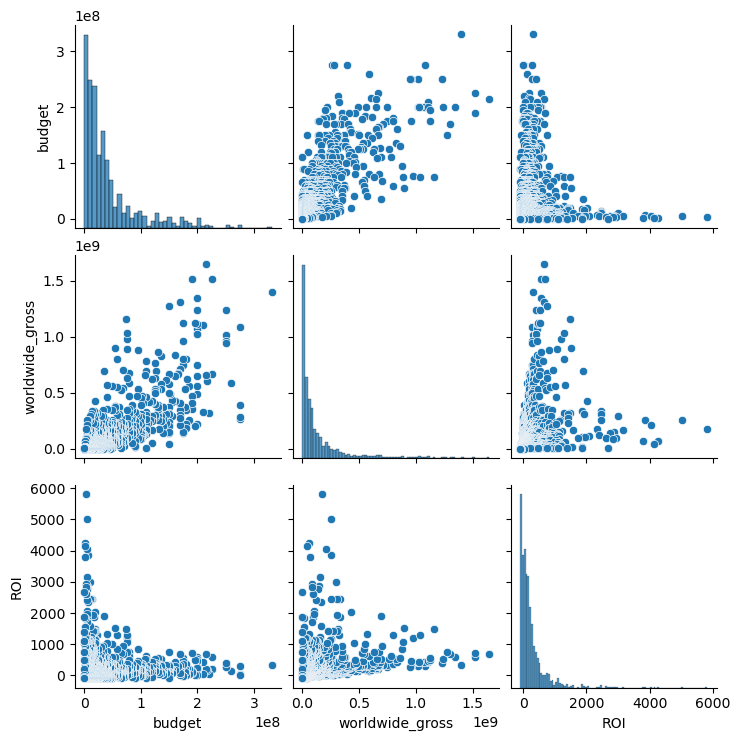

In [18]:
# Creating a pairplot to look for correlations between the data.
viz.eda_viz(movies_clean)

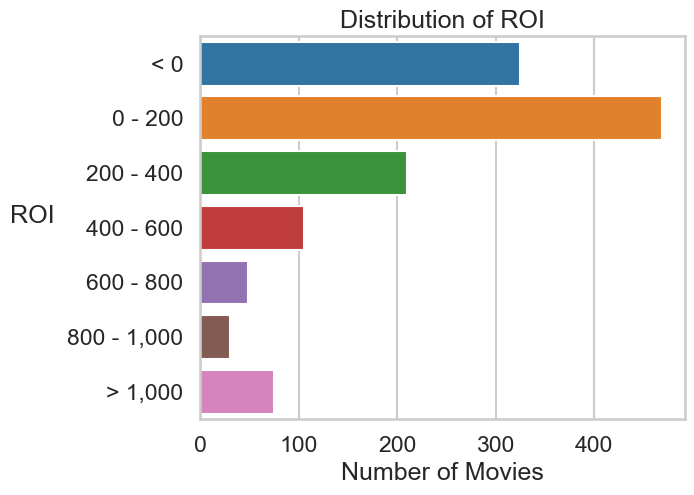

In [19]:
# Creating a countplot to show the distribution of the ROI of all movies in the dataset. 
viz.roi_viz(movies_clean)

## Evaluation

Once I had my list of producers, I could compare the movies they made to look for any patterns.  I chose budget, movie length, and most common genres as these would be parameters which Microsoft could control when making movies.

In [20]:
# Creating a summary table of the median values of numerical columns, grouped by producer_rank
movies_clean.drop_duplicates('movie_id').groupby('producer_rank').median()


,year,budget,worldwide_gross,runtime,ROI
producer_rank,,,,,
High ROI Producers,2015,6500000,95127344,99.0,1079.569540
Low ROI Producers,2012,53250000,104735513,115.5,39.106977
Mid ROI Producers,2014,25000000,54160818,106.0,119.199703


### Producers & Movie Length
Movies from producers with high ROI tended to have slightly shorter movies on average. A box plot has the advantage of showing the distribution of the data interest of just the measure of center. I excluded any outliers (1.5 times the IQR away from Q1 and Q3) to improve the visual. Excluding outliers also helps Microsoft to make business decisions based on what is most likely. 

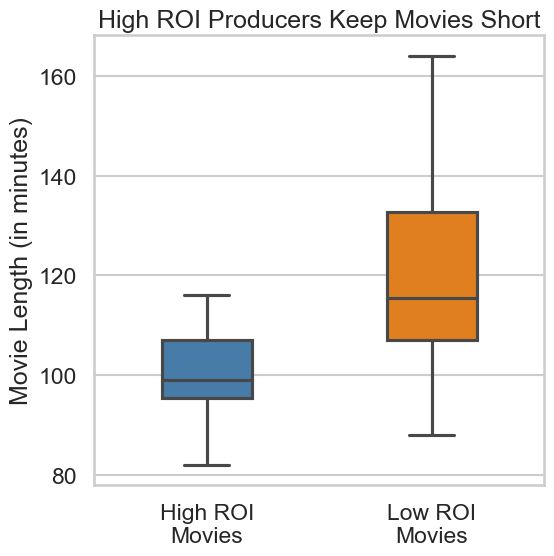

In [21]:
# Creating a visual comparing movie length of movies from high and low ROI producers.
viz.producer_runtime(movies_clean)

### Producers & Production Budget
This graph shows the stark difference in production budgets, with all of the movies from high ROI producers having a lower budget than over 75% of the movies from low ROI producers (excluding outliers). The movie budgets for the high ROI producers are also much more consistent than movies from low ROI producers.

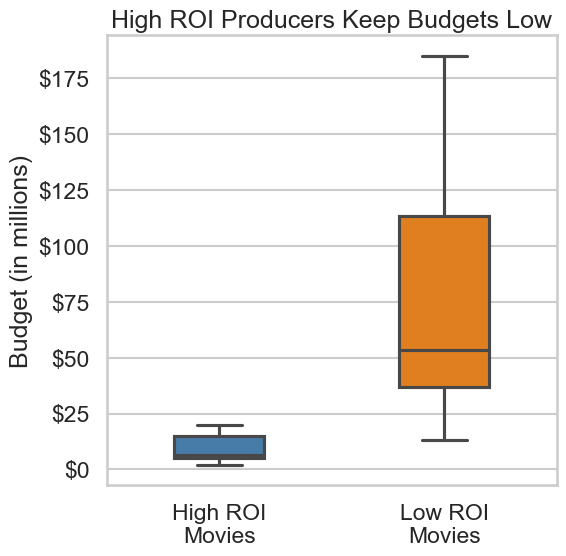

In [22]:
# Creating a visual comparing production budget of movies from high and low ROI producers.
viz.producer_budget(movies_clean)

### Producers & Genres
Initially, I looked at the most common occurring genre in each group. Then I decided to find the largest differences of frequency rate between the two groups. Displaying the differences between the groups makes it more clear which genres Microsoft should focus on or avoid. Lastly, I decided to display only the frequency of the movies from the High ROI producers for simplicity. 

Horror, thriller, and mystery genres occurred most often in the high ROI producers dataset.

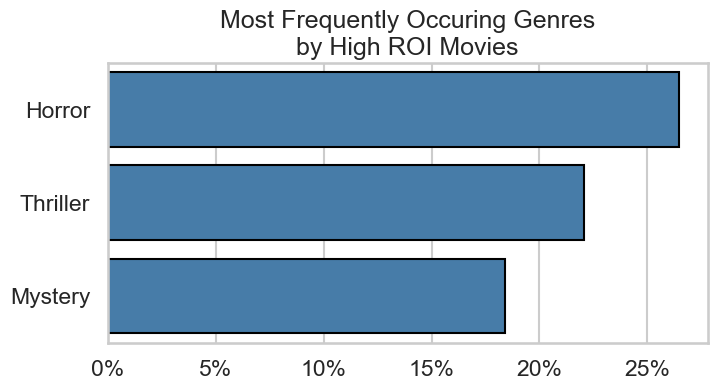

In [23]:
# Creating a visual to show the most frequently occuring genres in the high ROI producers movie set.
viz.producer_genre(movies_clean)

# Conclusions

This analysis leads to three recommendations:
- **Produce movies that are between 90 - 110 minutes.** The data shows that successful producers make movies slightly shorter than less successful producers. 
- **Keep production budgets low.** Producing movies for a cheaper price would allow Microsoft to make more movies, minimize the cost of producing unsuccessful movies, and maximizing the ROI for successful movies. 
- **Emphasize production of horror, thriller, and mystery movies.** Keeping these genres in mind when producing movies matches the market demand for movies and would help maximize ROI.

### Limitations
- The data only includes movies through 2019. This doesn't account for movie trends in the last three years. 
- Due to a lack of foreign key in either data set to merge on, it is possible we excluded some movies which were in both datasets. 
- Analysis was limited by the size of the dataset. Increasing the size could produce more representative results.  


### Next Steps
Further analysis could help improve decision making and success of Microsoft Movie Studios:
- **Study success by studio** More data is needed to categorize movies by movie studio. Then we could compare and contrast patterns between successful and not so successful movie studios. 
- **Analyze current data** The pandemic has had a notable affect on box office success. More analysis of recent data is needed to make informed decisions. 
- **Streaming service** Analyzing box office is only a piece of movie success these days. Analysis about profitability of streaming movies and/or creating one's own streaming service would keep Microsoft up to date with competitors. 